This notbook shows some basics of signal processing in **Obspy**. There is also a tutorial at https://docs.obspy.org/tutorial/ that can be useful.

In [4]:
import json
from obspy import Stream, Trace, UTCDateTime
import h5py
import numpy as np
%matplotlib inline

Import events

In [5]:
with h5py.File('earthquake_sample_events.h5', 'r') as fin:
    event_info_dataset = fin.get('event_info')
    trace_dataset = fin.get('traces')
    
    # Convert to numpy arrays
    eq_event_info = np.array(event_info_dataset)
    eq_trace_data = np.array(trace_dataset)

print(f'Loaded {eq_event_info.shape[0]} earthquake events')

Loaded 152 earthquake events


Get entries for a single event to look at

In [6]:
single_event_data = eq_trace_data[10]
single_event_info = eq_event_info[10]
single_event_info = json.loads(single_event_info)  # Convert JSON string to python dict

Now have a look at the info regarding the traces (waveforms)

In [7]:
print(single_event_info['trace_stats'])

{'starttime': '2019-01-06T01:25:51.275000Z', 'sampling_rate': 40.0, 'station': 'ARA0', 'channels': ['BHE', 'BHN', 'BHZ']}


Convert the date and time into an Obspy datetime object, which has some advantages over the native python one. All the times we use are in UTC / Greenwich.

In [8]:
start_time = UTCDateTime(single_event_info['trace_stats']['starttime'])
print(start_time)
print

2019-01-06T01:25:51.275000Z


<function print>

Now we'll make a Stream, which is a collection of several Trace's. A Trace is time series for an individual instrument channel at a station.

The meaning of the channel names (like _BHE_) are:
 1. Band code: _B_ means broadband (between 10 and 80 Hz)
 2. Instrument code: _H_ means high gain seismometer
 3. Orientation code: _E_ means East-West orientation, _N_: North-South, _Z_: Vertical

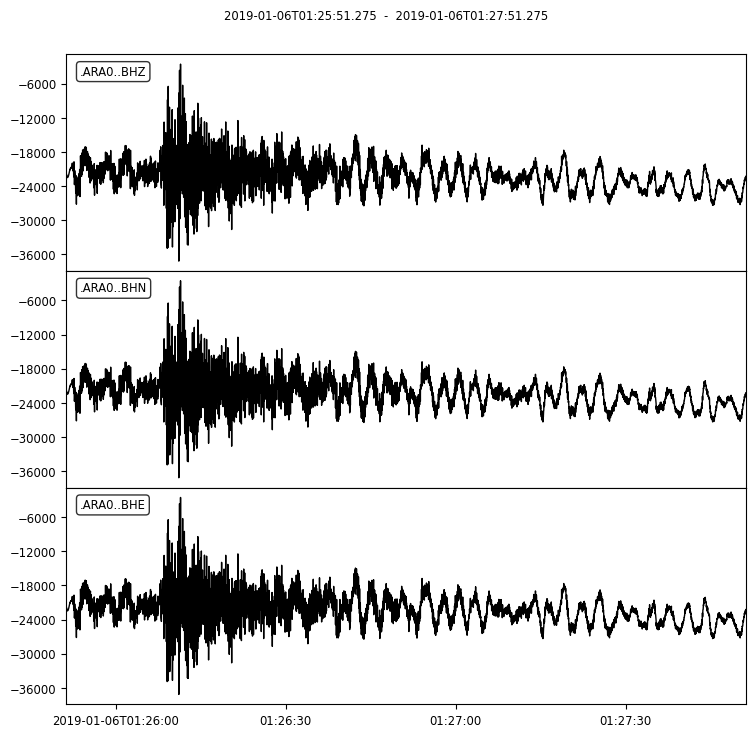

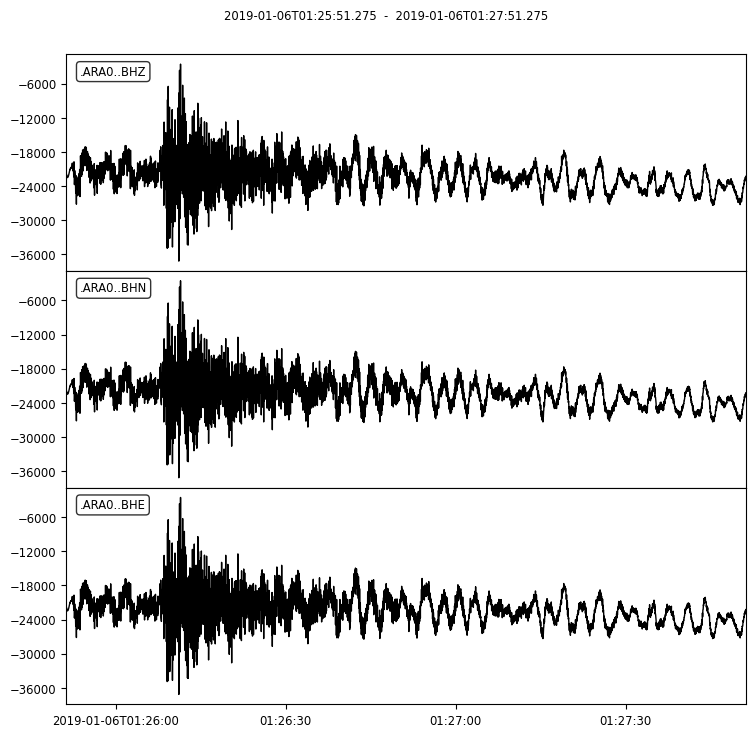

In [9]:
station = single_event_info['trace_stats']['station']
channels = single_event_info['trace_stats']['channels']
sampl_rate = single_event_info['trace_stats']['sampling_rate']

trace_BHE = Trace(
    data=single_event_data[0],
    header={
        'station': station,
        'channel': channels[0],
        'sampling_rate': sampl_rate,
        'starttime': start_time
    }
)

trace_BHN = Trace(
    data=single_event_data[0],
    header={
        'station': station,
        'channel': channels[1],
        'sampling_rate': sampl_rate, 
        'starttime': start_time
    }
)
trace_BHZ = Trace(
    data=single_event_data[0],
    header={
        'station': station,
        'channel': channels[2],
        'sampling_rate': sampl_rate,
        'starttime': start_time
    }
)

# Assemple into a Stream
stream = Stream([trace_BHE, trace_BHN, trace_BHZ])

# Plot it
stream.plot()

Now we can do all sorts of operations on all traces collectively.
Do some basic processing, see https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream

The plot above looks rather noisy, so we'll try to make the signal clearer to the human eye.

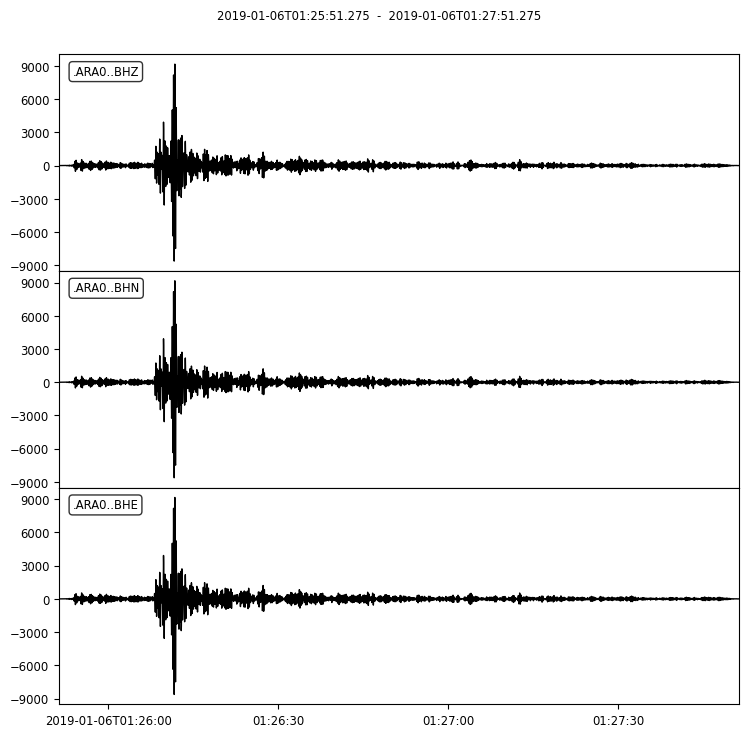

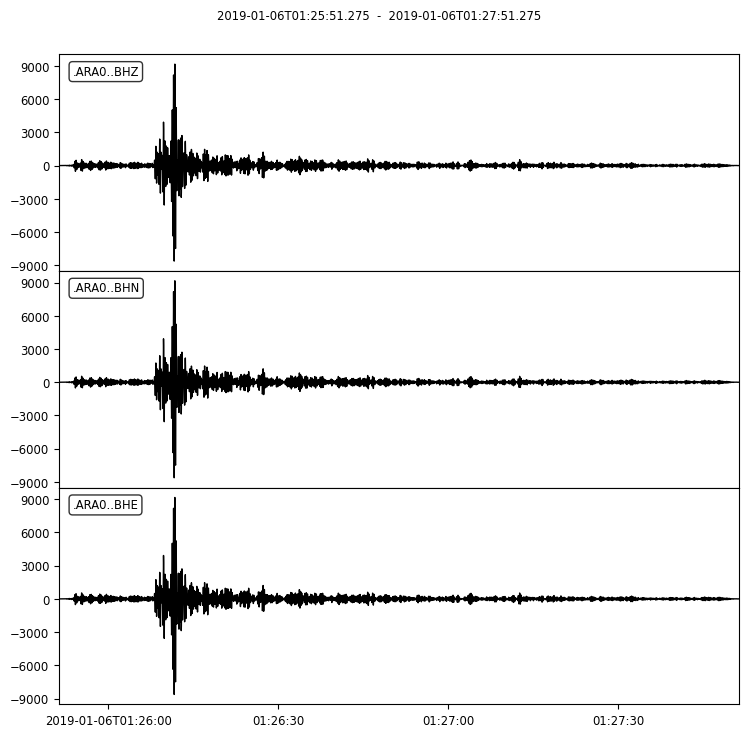

In [10]:
# Remove 'trend', e.g. remove linear offset from 0:
stream.detrend('demean')

# Taper the traces, meaning the ends will go gradually to 0 -- this is required before filtering
stream.taper(max_percentage=0.05, type='cosine')

# Apply a bandpass filter, selecting frequencies from 3 to 5 Hz
stream.filter('bandpass', freqmin=3.0, freqmax=5.0)

# Now we can plot it again, and see that the signal is more pronounced
stream.plot()